# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [ ]:
# run this once to unzip the file
!unzip processed-celeba-small.zip

In [2]:
from glob import glob
from typing import Tuple, Callable, Dict

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor

import tests

In [3]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [4]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize


def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = [
        Resize(size),
        ToTensor(),
        Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ]
    
    return Compose(transforms)

### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [5]:
import os

class DatasetDirectory(Dataset):
    """
    A custom dataset class that loads images from folder.
    args:
    - directory: location of the images
    - transform: transform function to apply to the images
    - extension: file format
    """
    def __init__(self, 
                 directory: str, 
                 transforms: Callable = None, 
                 extension: str = '.jpg'):
        super(DatasetDirectory, self).__init__()
        self.directory = directory
        self.transforms = transforms
        self.extension = extension

        self.image_files = [f for f in os.listdir(directory) if f.endswith(extension)]


    def __len__(self) -> int:
        """ returns the number of items in the dataset """
        return len(self.image_files)

    def __getitem__(self, index: int) -> torch.Tensor:
        """ load an image and apply transformation """
        image_file = self.image_files[index]
        image = Image.open(os.path.join(self.directory, image_file))
        image = self.transforms(image)
        return image


In [6]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

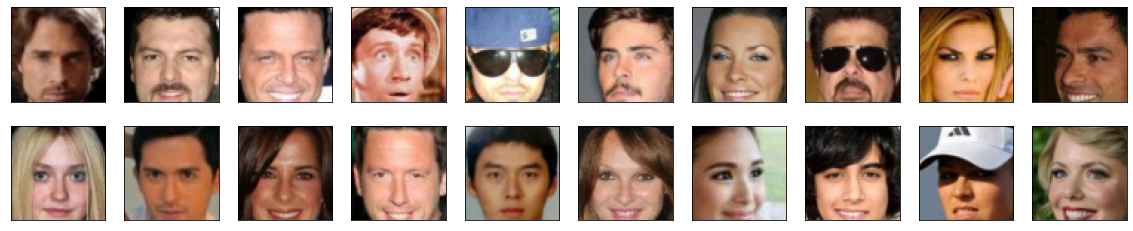

In [7]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [8]:
from torch.nn import Module
import torch.nn as nn

In [9]:

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.main = nn.Sequential(
            # 3 x 64 x 64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 64 x 32 x 32
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128 x 16 x 16
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 256 x 8 x 8
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # 512 x 4 x 4
            nn.Conv2d(512, 1, 4, stride=1, padding=0, bias=False),
            
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)


In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [11]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            # Z
            nn.ConvTranspose2d(latent_dim, latent_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(latent_dim * 8),
            nn.ReLU(True),

            # (latent_dim*8) x 4 x 4
            nn.ConvTranspose2d(latent_dim * 8, latent_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(latent_dim * 4),
            nn.ReLU(True),

            # (latent_dim*4) x 8 x 8
            nn.ConvTranspose2d(latent_dim * 4, latent_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(latent_dim * 2),
            nn.ReLU(True),

            # (latent_dim*2) x 16 x 16
            nn.ConvTranspose2d(latent_dim * 2, latent_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(latent_dim),
            nn.ReLU(True),

            # (latent_dim) x 32 x 32
            nn.ConvTranspose2d(latent_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # (3) x 64 x 64
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.main(x)


In [12]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [13]:
import torch.optim as optim


def create_optimizers(generator: Module, discriminator: Module):
    """ This function should return the optimizers of the generator and the discriminator """
    betas = (0.5, 0.999)
    
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001, betas=betas)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=betas)

    return g_optimizer, d_optimizer


## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [14]:
def generator_loss(fake_logits):
    """ Generator loss, takes the fake scores as inputs. """
    target = torch.ones_like(fake_logits)
    loss = nn.BCEWithLogitsLoss()(fake_logits, target)

    return loss

### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [15]:
def discriminator_loss(real_logits, fake_logits):
    """ Discriminator loss, takes the fake and real logits as inputs. """
    real_target = torch.ones_like(real_logits)
    fake_target = torch.zeros_like(fake_logits)
    
    real_loss = nn.BCEWithLogitsLoss()(real_logits, real_target)
    fake_loss = nn.BCEWithLogitsLoss()(fake_logits, fake_target)

    return real_loss + fake_loss


### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [16]:
def gradient_penalty(discriminator, real_samples, fake_samples):
    # Create interpolated samples between real and fake samples
    alpha = torch.rand(real_samples.size(0), 1, 1, 1).to(real_samples.device)
    interpolated_samples = alpha * real_samples.detach() + (1 - alpha) * fake_samples.detach()
    interpolated_samples.requires_grad = True

    # Calculate discriminator output for interpolated samples
    d_interpolates = discriminator(interpolated_samples)

    # Calculate gradients of discriminator output w.r.t. interpolated samples
    gradients = torch.autograd.grad(
        outputs=d_interpolates, 
        inputs=interpolated_samples,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True, retain_graph=True, only_inputs=True
    )[0]

    # Calculate gradient penalty
    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()

    return gradient_penalty

## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [22]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [29]:
def generator_step(generator: torch.nn.Module, discriminator: torch.nn.Module, batch_size: int, latent_dim: int, optimizer: torch.optim.Optimizer) -> Dict:
    """ One training step of the generator. """
    # Create latent vectors
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

    # Generate fake images
    fake_images = generator(z)
    
    # Compute generator loss
    fake_logits = discriminator(fake_images)
    g_loss = generator_loss(fake_logits)
    
    # Backpropagation
    optimizer.zero_grad()
    g_loss.backward()
    
    # Update weights
    optimizer.step()

    return {'loss': g_loss.item()}


def discriminator_step(generator: torch.nn.Module, discriminator: torch.nn.Module, batch_size: int, latent_dim: int, real_images: torch.Tensor, optimizer: torch.optim.Optimizer) -> Dict:
    """ One training step of the discriminator. """
    # Create latent vectors
    z = torch.randn(batch_size, latent_dim, 1, 1).to(device)

    # Generate fake images
    fake_images = generator(z)
    
    # Compute discriminator loss
    real_logits = discriminator(real_images)
    fake_logits = discriminator(fake_images)
    d_loss = discriminator_loss(real_logits, fake_logits)

    # Optionally compute gradient penalty
    gp = gradient_penalty(discriminator, real_images, fake_images) if gradient_penalty else 0.0

    # Backpropagation
    optimizer.zero_grad()
    (d_loss + gp).backward()
    
    # Update weights
    optimizer.step()

    return {'loss': d_loss.item()}



### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [30]:
from datetime import datetime

In [31]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
# device = 'cuda'

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

In [39]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [40]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2023-06-22 17:34:31 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3824 | g_loss: 0.7734
2023-06-22 17:35:04 | Epoch [1/20] | Batch 50/509 | d_loss: 0.1057 | g_loss: 11.2322
2023-06-22 17:35:37 | Epoch [1/20] | Batch 100/509 | d_loss: 0.0019 | g_loss: 8.4469
2023-06-22 17:36:10 | Epoch [1/20] | Batch 150/509 | d_loss: 0.0026 | g_loss: 7.3777
2023-06-22 17:36:43 | Epoch [1/20] | Batch 200/509 | d_loss: 0.6497 | g_loss: 2.6562
2023-06-22 17:37:16 | Epoch [1/20] | Batch 250/509 | d_loss: 0.7563 | g_loss: 2.0668
2023-06-22 17:37:49 | Epoch [1/20] | Batch 300/509 | d_loss: 1.0015 | g_loss: 1.3198
2023-06-22 17:38:22 | Epoch [1/20] | Batch 350/509 | d_loss: 1.1491 | g_loss: 1.2521
2023-06-22 17:38:55 | Epoch [1/20] | Batch 400/509 | d_loss: 0.9058 | g_loss: 1.3393
2023-06-22 17:39:28 | Epoch [1/20] | Batch 450/509 | d_loss: 1.0781 | g_loss: 0.8824
2023-06-22 17:40:01 | Epoch [1/20] | Batch 500/509 | d_loss: 0.9387 | g_loss: 1.4332


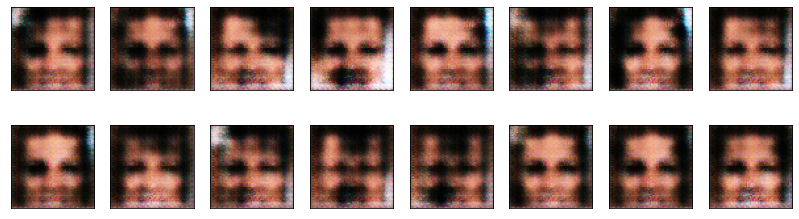

2023-06-22 17:40:08 | Epoch [2/20] | Batch 0/509 | d_loss: 1.7645 | g_loss: 1.7087
2023-06-22 17:40:41 | Epoch [2/20] | Batch 50/509 | d_loss: 1.4896 | g_loss: 1.0019
2023-06-22 17:41:14 | Epoch [2/20] | Batch 100/509 | d_loss: 0.9189 | g_loss: 1.1518
2023-06-22 17:41:47 | Epoch [2/20] | Batch 150/509 | d_loss: 1.2908 | g_loss: 0.9882
2023-06-22 17:42:20 | Epoch [2/20] | Batch 200/509 | d_loss: 0.9241 | g_loss: 1.1581
2023-06-22 17:42:53 | Epoch [2/20] | Batch 250/509 | d_loss: 0.9666 | g_loss: 0.8752
2023-06-22 17:43:26 | Epoch [2/20] | Batch 300/509 | d_loss: 0.8180 | g_loss: 1.2167
2023-06-22 17:43:59 | Epoch [2/20] | Batch 350/509 | d_loss: 0.9669 | g_loss: 1.4232
2023-06-22 17:44:32 | Epoch [2/20] | Batch 400/509 | d_loss: 1.0980 | g_loss: 1.4399
2023-06-22 17:45:05 | Epoch [2/20] | Batch 450/509 | d_loss: 0.9466 | g_loss: 1.3403
2023-06-22 17:45:38 | Epoch [2/20] | Batch 500/509 | d_loss: 1.0091 | g_loss: 1.3077


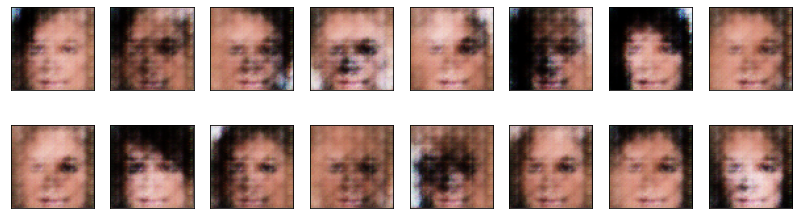

2023-06-22 17:45:46 | Epoch [3/20] | Batch 0/509 | d_loss: 1.0123 | g_loss: 1.0551
2023-06-22 17:46:19 | Epoch [3/20] | Batch 50/509 | d_loss: 1.1189 | g_loss: 1.3055
2023-06-22 17:46:52 | Epoch [3/20] | Batch 100/509 | d_loss: 1.0352 | g_loss: 1.1046
2023-06-22 17:47:25 | Epoch [3/20] | Batch 150/509 | d_loss: 1.2024 | g_loss: 1.2284
2023-06-22 17:47:58 | Epoch [3/20] | Batch 200/509 | d_loss: 0.9533 | g_loss: 1.1811
2023-06-22 17:48:31 | Epoch [3/20] | Batch 250/509 | d_loss: 1.1934 | g_loss: 1.1181
2023-06-22 17:49:03 | Epoch [3/20] | Batch 300/509 | d_loss: 0.8175 | g_loss: 1.0405
2023-06-22 17:49:36 | Epoch [3/20] | Batch 350/509 | d_loss: 0.7946 | g_loss: 1.6011
2023-06-22 17:50:09 | Epoch [3/20] | Batch 400/509 | d_loss: 0.8371 | g_loss: 1.2041
2023-06-22 17:50:42 | Epoch [3/20] | Batch 450/509 | d_loss: 0.9466 | g_loss: 1.3413
2023-06-22 17:51:15 | Epoch [3/20] | Batch 500/509 | d_loss: 1.0029 | g_loss: 1.2566


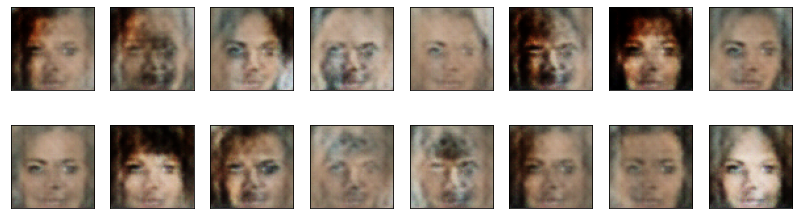

2023-06-22 17:51:22 | Epoch [4/20] | Batch 0/509 | d_loss: 0.9039 | g_loss: 1.0612
2023-06-22 17:51:55 | Epoch [4/20] | Batch 50/509 | d_loss: 0.9590 | g_loss: 1.0428
2023-06-22 17:52:28 | Epoch [4/20] | Batch 100/509 | d_loss: 1.0119 | g_loss: 1.0723
2023-06-22 17:53:01 | Epoch [4/20] | Batch 150/509 | d_loss: 0.9789 | g_loss: 0.8028
2023-06-22 17:53:34 | Epoch [4/20] | Batch 200/509 | d_loss: 0.8670 | g_loss: 1.4231
2023-06-22 17:54:07 | Epoch [4/20] | Batch 250/509 | d_loss: 0.7470 | g_loss: 1.4146
2023-06-22 17:54:40 | Epoch [4/20] | Batch 300/509 | d_loss: 0.9769 | g_loss: 1.1799
2023-06-22 17:55:13 | Epoch [4/20] | Batch 350/509 | d_loss: 0.8478 | g_loss: 1.2162
2023-06-22 17:55:47 | Epoch [4/20] | Batch 400/509 | d_loss: 1.1730 | g_loss: 1.0097
2023-06-22 17:56:20 | Epoch [4/20] | Batch 450/509 | d_loss: 0.9163 | g_loss: 1.0459
2023-06-22 17:56:53 | Epoch [4/20] | Batch 500/509 | d_loss: 0.9625 | g_loss: 0.9424


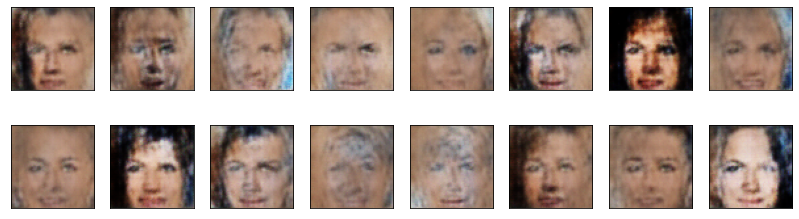

2023-06-22 17:57:00 | Epoch [5/20] | Batch 0/509 | d_loss: 1.0270 | g_loss: 1.1046
2023-06-22 17:57:33 | Epoch [5/20] | Batch 50/509 | d_loss: 1.0447 | g_loss: 1.2518
2023-06-22 17:58:06 | Epoch [5/20] | Batch 100/509 | d_loss: 1.0647 | g_loss: 1.0105
2023-06-22 17:58:39 | Epoch [5/20] | Batch 150/509 | d_loss: 1.0278 | g_loss: 1.0783
2023-06-22 17:59:13 | Epoch [5/20] | Batch 200/509 | d_loss: 1.0646 | g_loss: 1.1318
2023-06-22 17:59:46 | Epoch [5/20] | Batch 250/509 | d_loss: 0.9791 | g_loss: 1.0491
2023-06-22 18:00:19 | Epoch [5/20] | Batch 300/509 | d_loss: 0.9983 | g_loss: 1.1984
2023-06-22 18:00:52 | Epoch [5/20] | Batch 350/509 | d_loss: 0.9591 | g_loss: 1.1117
2023-06-22 18:01:25 | Epoch [5/20] | Batch 400/509 | d_loss: 0.9868 | g_loss: 1.3305
2023-06-22 18:01:58 | Epoch [5/20] | Batch 450/509 | d_loss: 0.9065 | g_loss: 1.0876
2023-06-22 18:02:31 | Epoch [5/20] | Batch 500/509 | d_loss: 0.9786 | g_loss: 1.4047


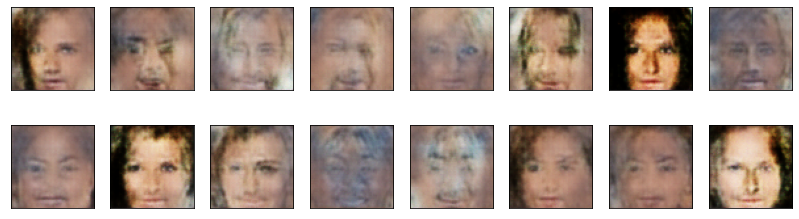

2023-06-22 18:02:38 | Epoch [6/20] | Batch 0/509 | d_loss: 0.9957 | g_loss: 0.9728
2023-06-22 18:03:11 | Epoch [6/20] | Batch 50/509 | d_loss: 0.9296 | g_loss: 0.9796
2023-06-22 18:03:44 | Epoch [6/20] | Batch 100/509 | d_loss: 0.9794 | g_loss: 1.2219
2023-06-22 18:04:17 | Epoch [6/20] | Batch 150/509 | d_loss: 1.0082 | g_loss: 0.8882
2023-06-22 18:04:50 | Epoch [6/20] | Batch 200/509 | d_loss: 0.8904 | g_loss: 1.0193
2023-06-22 18:05:23 | Epoch [6/20] | Batch 250/509 | d_loss: 0.9954 | g_loss: 1.0072
2023-06-22 18:05:56 | Epoch [6/20] | Batch 300/509 | d_loss: 0.8978 | g_loss: 1.2472
2023-06-22 18:06:29 | Epoch [6/20] | Batch 350/509 | d_loss: 1.0282 | g_loss: 0.9570
2023-06-22 18:07:02 | Epoch [6/20] | Batch 400/509 | d_loss: 0.9460 | g_loss: 0.9826
2023-06-22 18:07:35 | Epoch [6/20] | Batch 450/509 | d_loss: 1.1076 | g_loss: 0.6761
2023-06-22 18:08:08 | Epoch [6/20] | Batch 500/509 | d_loss: 1.0034 | g_loss: 1.0698


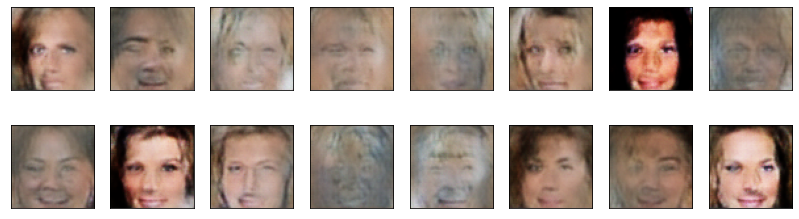

2023-06-22 18:08:15 | Epoch [7/20] | Batch 0/509 | d_loss: 0.9418 | g_loss: 0.8607
2023-06-22 18:08:48 | Epoch [7/20] | Batch 50/509 | d_loss: 1.0121 | g_loss: 0.7799
2023-06-22 18:09:21 | Epoch [7/20] | Batch 100/509 | d_loss: 1.1761 | g_loss: 1.1314
2023-06-22 18:09:54 | Epoch [7/20] | Batch 150/509 | d_loss: 0.9920 | g_loss: 1.0785
2023-06-22 18:10:27 | Epoch [7/20] | Batch 200/509 | d_loss: 0.9578 | g_loss: 1.0136
2023-06-22 18:11:00 | Epoch [7/20] | Batch 250/509 | d_loss: 1.1513 | g_loss: 1.1496
2023-06-22 18:11:33 | Epoch [7/20] | Batch 300/509 | d_loss: 0.9492 | g_loss: 0.9730
2023-06-22 18:12:06 | Epoch [7/20] | Batch 350/509 | d_loss: 0.9610 | g_loss: 1.3861
2023-06-22 18:12:39 | Epoch [7/20] | Batch 400/509 | d_loss: 0.9846 | g_loss: 1.2500
2023-06-22 18:13:12 | Epoch [7/20] | Batch 450/509 | d_loss: 0.9667 | g_loss: 1.1154
2023-06-22 18:13:45 | Epoch [7/20] | Batch 500/509 | d_loss: 0.8486 | g_loss: 1.0149


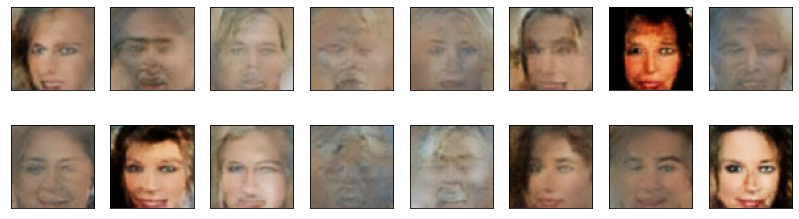

2023-06-22 18:13:52 | Epoch [8/20] | Batch 0/509 | d_loss: 1.0283 | g_loss: 1.4227
2023-06-22 18:14:25 | Epoch [8/20] | Batch 50/509 | d_loss: 0.8939 | g_loss: 0.9776
2023-06-22 18:14:59 | Epoch [8/20] | Batch 100/509 | d_loss: 0.8697 | g_loss: 1.0288
2023-06-22 18:15:32 | Epoch [8/20] | Batch 150/509 | d_loss: 0.9484 | g_loss: 1.0265
2023-06-22 18:16:05 | Epoch [8/20] | Batch 200/509 | d_loss: 0.9951 | g_loss: 1.0863
2023-06-22 18:16:38 | Epoch [8/20] | Batch 250/509 | d_loss: 1.0370 | g_loss: 1.0595
2023-06-22 18:17:11 | Epoch [8/20] | Batch 300/509 | d_loss: 1.0029 | g_loss: 1.0585
2023-06-22 18:17:44 | Epoch [8/20] | Batch 350/509 | d_loss: 0.9164 | g_loss: 1.0049
2023-06-22 18:18:17 | Epoch [8/20] | Batch 400/509 | d_loss: 1.0536 | g_loss: 0.9474
2023-06-22 18:18:50 | Epoch [8/20] | Batch 450/509 | d_loss: 0.9933 | g_loss: 0.9156
2023-06-22 18:19:23 | Epoch [8/20] | Batch 500/509 | d_loss: 0.9056 | g_loss: 1.2947


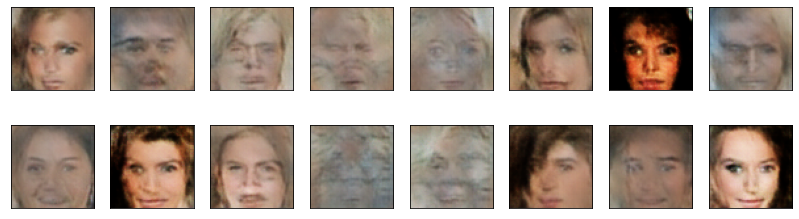

2023-06-22 18:19:30 | Epoch [9/20] | Batch 0/509 | d_loss: 1.0528 | g_loss: 0.9234
2023-06-22 18:20:03 | Epoch [9/20] | Batch 50/509 | d_loss: 1.1451 | g_loss: 1.2089
2023-06-22 18:20:36 | Epoch [9/20] | Batch 100/509 | d_loss: 1.0349 | g_loss: 0.6996
2023-06-22 18:21:09 | Epoch [9/20] | Batch 150/509 | d_loss: 1.0882 | g_loss: 1.1392
2023-06-22 18:21:42 | Epoch [9/20] | Batch 200/509 | d_loss: 1.0857 | g_loss: 0.7554
2023-06-22 18:22:15 | Epoch [9/20] | Batch 250/509 | d_loss: 1.0475 | g_loss: 0.8929
2023-06-22 18:22:48 | Epoch [9/20] | Batch 300/509 | d_loss: 0.9896 | g_loss: 1.0425
2023-06-22 18:23:21 | Epoch [9/20] | Batch 350/509 | d_loss: 0.9972 | g_loss: 0.9130
2023-06-22 18:23:54 | Epoch [9/20] | Batch 400/509 | d_loss: 1.0264 | g_loss: 0.9453
2023-06-22 18:24:27 | Epoch [9/20] | Batch 450/509 | d_loss: 1.1970 | g_loss: 1.0876
2023-06-22 18:25:00 | Epoch [9/20] | Batch 500/509 | d_loss: 1.1040 | g_loss: 1.1274


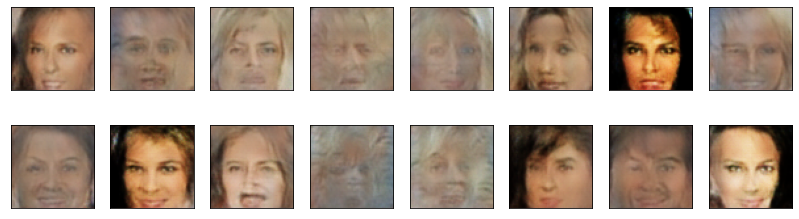

2023-06-22 18:25:07 | Epoch [10/20] | Batch 0/509 | d_loss: 0.9344 | g_loss: 1.1720
2023-06-22 18:25:40 | Epoch [10/20] | Batch 50/509 | d_loss: 1.0102 | g_loss: 0.7992
2023-06-22 18:26:13 | Epoch [10/20] | Batch 100/509 | d_loss: 1.0953 | g_loss: 1.0313
2023-06-22 18:26:46 | Epoch [10/20] | Batch 150/509 | d_loss: 0.9321 | g_loss: 0.9407
2023-06-22 18:27:19 | Epoch [10/20] | Batch 200/509 | d_loss: 1.2272 | g_loss: 0.8828
2023-06-22 18:27:52 | Epoch [10/20] | Batch 250/509 | d_loss: 1.0667 | g_loss: 1.0924
2023-06-22 18:28:25 | Epoch [10/20] | Batch 300/509 | d_loss: 0.9647 | g_loss: 0.9822
2023-06-22 18:28:58 | Epoch [10/20] | Batch 350/509 | d_loss: 1.0380 | g_loss: 0.8649
2023-06-22 18:29:31 | Epoch [10/20] | Batch 400/509 | d_loss: 1.1417 | g_loss: 0.7046
2023-06-22 18:30:03 | Epoch [10/20] | Batch 450/509 | d_loss: 1.0814 | g_loss: 0.6991
2023-06-22 18:30:36 | Epoch [10/20] | Batch 500/509 | d_loss: 0.9981 | g_loss: 0.9103


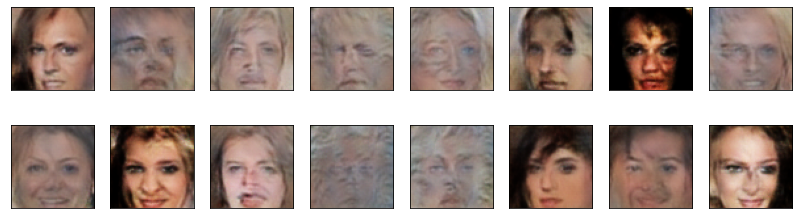

2023-06-22 18:30:43 | Epoch [11/20] | Batch 0/509 | d_loss: 1.0643 | g_loss: 0.9337
2023-06-22 18:31:16 | Epoch [11/20] | Batch 50/509 | d_loss: 1.0730 | g_loss: 1.1294
2023-06-22 18:31:49 | Epoch [11/20] | Batch 100/509 | d_loss: 1.0592 | g_loss: 0.8422
2023-06-22 18:32:22 | Epoch [11/20] | Batch 150/509 | d_loss: 1.0813 | g_loss: 1.0545
2023-06-22 18:32:55 | Epoch [11/20] | Batch 200/509 | d_loss: 1.0651 | g_loss: 0.8495
2023-06-22 18:33:28 | Epoch [11/20] | Batch 250/509 | d_loss: 1.0992 | g_loss: 0.9308
2023-06-22 18:34:01 | Epoch [11/20] | Batch 300/509 | d_loss: 1.0874 | g_loss: 0.9502
2023-06-22 18:34:34 | Epoch [11/20] | Batch 350/509 | d_loss: 1.0678 | g_loss: 1.1217
2023-06-22 18:35:07 | Epoch [11/20] | Batch 400/509 | d_loss: 1.0323 | g_loss: 0.8368
2023-06-22 18:35:40 | Epoch [11/20] | Batch 450/509 | d_loss: 1.0832 | g_loss: 0.8846
2023-06-22 18:36:13 | Epoch [11/20] | Batch 500/509 | d_loss: 1.0998 | g_loss: 0.8413


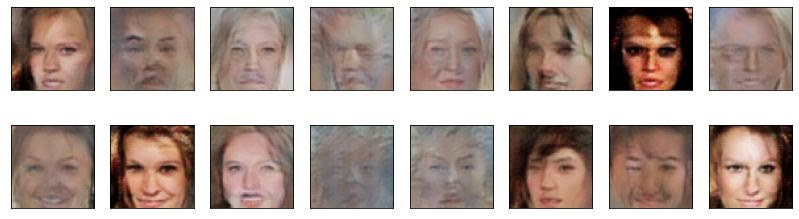

2023-06-22 18:36:20 | Epoch [12/20] | Batch 0/509 | d_loss: 1.1354 | g_loss: 0.9568
2023-06-22 18:36:52 | Epoch [12/20] | Batch 50/509 | d_loss: 1.0849 | g_loss: 1.1225
2023-06-22 18:37:25 | Epoch [12/20] | Batch 100/509 | d_loss: 1.0872 | g_loss: 0.8381
2023-06-22 18:37:57 | Epoch [12/20] | Batch 150/509 | d_loss: 1.0904 | g_loss: 1.3265
2023-06-22 18:38:30 | Epoch [12/20] | Batch 200/509 | d_loss: 1.0422 | g_loss: 0.9157
2023-06-22 18:39:02 | Epoch [12/20] | Batch 250/509 | d_loss: 1.1435 | g_loss: 1.1804
2023-06-22 18:39:35 | Epoch [12/20] | Batch 300/509 | d_loss: 1.0206 | g_loss: 1.1260
2023-06-22 18:40:08 | Epoch [12/20] | Batch 350/509 | d_loss: 0.9716 | g_loss: 1.0332
2023-06-22 18:40:40 | Epoch [12/20] | Batch 400/509 | d_loss: 1.1200 | g_loss: 1.0740
2023-06-22 18:41:13 | Epoch [12/20] | Batch 450/509 | d_loss: 1.0445 | g_loss: 1.2770
2023-06-22 18:41:45 | Epoch [12/20] | Batch 500/509 | d_loss: 0.9899 | g_loss: 0.7468


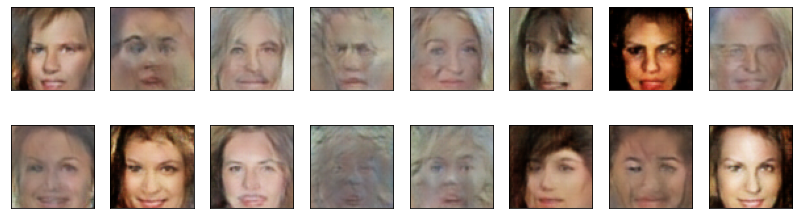

2023-06-22 18:41:52 | Epoch [13/20] | Batch 0/509 | d_loss: 1.1595 | g_loss: 0.9928
2023-06-22 18:42:25 | Epoch [13/20] | Batch 50/509 | d_loss: 1.0587 | g_loss: 1.0025
2023-06-22 18:42:58 | Epoch [13/20] | Batch 100/509 | d_loss: 1.1108 | g_loss: 0.8963
2023-06-22 18:43:31 | Epoch [13/20] | Batch 150/509 | d_loss: 1.0639 | g_loss: 0.8511
2023-06-22 18:44:04 | Epoch [13/20] | Batch 200/509 | d_loss: 1.0444 | g_loss: 0.8875
2023-06-22 18:44:37 | Epoch [13/20] | Batch 250/509 | d_loss: 1.1533 | g_loss: 0.8114
2023-06-22 18:45:10 | Epoch [13/20] | Batch 300/509 | d_loss: 1.0509 | g_loss: 0.9688
2023-06-22 18:45:43 | Epoch [13/20] | Batch 350/509 | d_loss: 1.0190 | g_loss: 1.1552
2023-06-22 18:46:16 | Epoch [13/20] | Batch 400/509 | d_loss: 1.1350 | g_loss: 0.8700
2023-06-22 18:46:49 | Epoch [13/20] | Batch 450/509 | d_loss: 1.0444 | g_loss: 1.1270
2023-06-22 18:47:22 | Epoch [13/20] | Batch 500/509 | d_loss: 1.1097 | g_loss: 1.4794


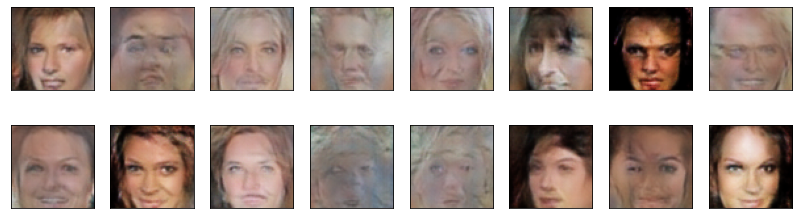

2023-06-22 18:47:29 | Epoch [14/20] | Batch 0/509 | d_loss: 1.0060 | g_loss: 0.9936
2023-06-22 18:48:02 | Epoch [14/20] | Batch 50/509 | d_loss: 1.2307 | g_loss: 0.5877
2023-06-22 18:48:36 | Epoch [14/20] | Batch 100/509 | d_loss: 1.0508 | g_loss: 0.9384
2023-06-22 18:49:09 | Epoch [14/20] | Batch 150/509 | d_loss: 1.0003 | g_loss: 1.3676
2023-06-22 18:49:42 | Epoch [14/20] | Batch 200/509 | d_loss: 1.0757 | g_loss: 1.0301
2023-06-22 18:50:15 | Epoch [14/20] | Batch 250/509 | d_loss: 0.9993 | g_loss: 0.9872
2023-06-22 18:50:48 | Epoch [14/20] | Batch 300/509 | d_loss: 1.0722 | g_loss: 0.8832
2023-06-22 18:51:21 | Epoch [14/20] | Batch 350/509 | d_loss: 1.1155 | g_loss: 1.1003
2023-06-22 18:51:54 | Epoch [14/20] | Batch 400/509 | d_loss: 1.0490 | g_loss: 0.7641
2023-06-22 18:52:27 | Epoch [14/20] | Batch 450/509 | d_loss: 1.0568 | g_loss: 1.0301
2023-06-22 18:53:00 | Epoch [14/20] | Batch 500/509 | d_loss: 1.1752 | g_loss: 0.9975


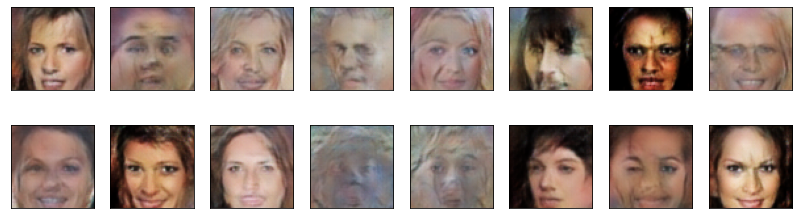

2023-06-22 18:53:07 | Epoch [15/20] | Batch 0/509 | d_loss: 1.0161 | g_loss: 0.9254
2023-06-22 18:53:40 | Epoch [15/20] | Batch 50/509 | d_loss: 1.0804 | g_loss: 1.1423
2023-06-22 18:54:13 | Epoch [15/20] | Batch 100/509 | d_loss: 1.1385 | g_loss: 0.9653
2023-06-22 18:54:46 | Epoch [15/20] | Batch 150/509 | d_loss: 1.0028 | g_loss: 1.1050
2023-06-22 18:55:19 | Epoch [15/20] | Batch 200/509 | d_loss: 1.1183 | g_loss: 1.3279
2023-06-22 18:55:52 | Epoch [15/20] | Batch 250/509 | d_loss: 1.0632 | g_loss: 0.8686
2023-06-22 18:56:25 | Epoch [15/20] | Batch 300/509 | d_loss: 1.1575 | g_loss: 0.8069
2023-06-22 18:56:58 | Epoch [15/20] | Batch 350/509 | d_loss: 1.1442 | g_loss: 0.9156
2023-06-22 18:57:31 | Epoch [15/20] | Batch 400/509 | d_loss: 1.0635 | g_loss: 0.7224
2023-06-22 18:58:04 | Epoch [15/20] | Batch 450/509 | d_loss: 1.0866 | g_loss: 1.1790
2023-06-22 18:58:37 | Epoch [15/20] | Batch 500/509 | d_loss: 1.0898 | g_loss: 1.1389


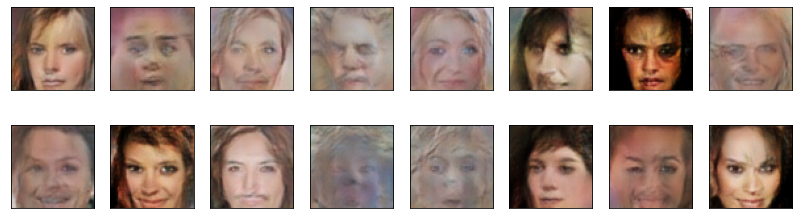

2023-06-22 18:58:44 | Epoch [16/20] | Batch 0/509 | d_loss: 1.1162 | g_loss: 1.1069
2023-06-22 18:59:17 | Epoch [16/20] | Batch 50/509 | d_loss: 1.0541 | g_loss: 0.9010
2023-06-22 18:59:50 | Epoch [16/20] | Batch 100/509 | d_loss: 1.1473 | g_loss: 1.1976
2023-06-22 19:00:23 | Epoch [16/20] | Batch 150/509 | d_loss: 1.1285 | g_loss: 0.9106
2023-06-22 19:00:56 | Epoch [16/20] | Batch 200/509 | d_loss: 1.0989 | g_loss: 0.8214
2023-06-22 19:01:29 | Epoch [16/20] | Batch 250/509 | d_loss: 1.0843 | g_loss: 1.0820
2023-06-22 19:02:02 | Epoch [16/20] | Batch 300/509 | d_loss: 1.0556 | g_loss: 0.8522
2023-06-22 19:02:35 | Epoch [16/20] | Batch 350/509 | d_loss: 1.0317 | g_loss: 1.0138
2023-06-22 19:03:08 | Epoch [16/20] | Batch 400/509 | d_loss: 1.1659 | g_loss: 0.7734
2023-06-22 19:03:41 | Epoch [16/20] | Batch 450/509 | d_loss: 1.1141 | g_loss: 0.8787
2023-06-22 19:04:15 | Epoch [16/20] | Batch 500/509 | d_loss: 1.1811 | g_loss: 0.9086


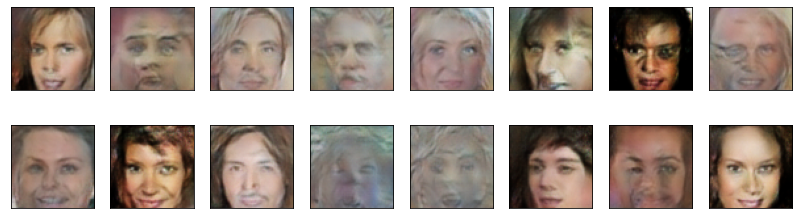

2023-06-22 19:04:22 | Epoch [17/20] | Batch 0/509 | d_loss: 1.0004 | g_loss: 1.0399
2023-06-22 19:04:55 | Epoch [17/20] | Batch 50/509 | d_loss: 1.2170 | g_loss: 0.7268
2023-06-22 19:05:28 | Epoch [17/20] | Batch 100/509 | d_loss: 1.0327 | g_loss: 0.8904
2023-06-22 19:06:01 | Epoch [17/20] | Batch 150/509 | d_loss: 1.1059 | g_loss: 0.8698
2023-06-22 19:06:34 | Epoch [17/20] | Batch 200/509 | d_loss: 1.1390 | g_loss: 0.7846
2023-06-22 19:07:07 | Epoch [17/20] | Batch 250/509 | d_loss: 1.1251 | g_loss: 0.6604
2023-06-22 19:07:40 | Epoch [17/20] | Batch 300/509 | d_loss: 1.1275 | g_loss: 0.9255
2023-06-22 19:08:13 | Epoch [17/20] | Batch 350/509 | d_loss: 1.1265 | g_loss: 0.7589
2023-06-22 19:08:46 | Epoch [17/20] | Batch 400/509 | d_loss: 1.0942 | g_loss: 0.7485
2023-06-22 19:09:19 | Epoch [17/20] | Batch 450/509 | d_loss: 1.0760 | g_loss: 0.7770
2023-06-22 19:09:52 | Epoch [17/20] | Batch 500/509 | d_loss: 1.0948 | g_loss: 0.8197


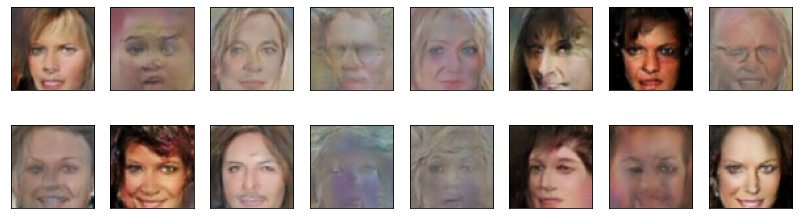

2023-06-22 19:09:59 | Epoch [18/20] | Batch 0/509 | d_loss: 1.0649 | g_loss: 0.9137
2023-06-22 19:10:32 | Epoch [18/20] | Batch 50/509 | d_loss: 1.0721 | g_loss: 0.7755
2023-06-22 19:11:05 | Epoch [18/20] | Batch 100/509 | d_loss: 1.1174 | g_loss: 0.9622
2023-06-22 19:11:38 | Epoch [18/20] | Batch 150/509 | d_loss: 1.0367 | g_loss: 0.8449
2023-06-22 19:12:11 | Epoch [18/20] | Batch 200/509 | d_loss: 1.1022 | g_loss: 0.8131
2023-06-22 19:12:44 | Epoch [18/20] | Batch 250/509 | d_loss: 1.2002 | g_loss: 0.9510
2023-06-22 19:13:17 | Epoch [18/20] | Batch 300/509 | d_loss: 1.0797 | g_loss: 0.8237
2023-06-22 19:13:50 | Epoch [18/20] | Batch 350/509 | d_loss: 1.0431 | g_loss: 0.9771
2023-06-22 19:14:23 | Epoch [18/20] | Batch 400/509 | d_loss: 1.1206 | g_loss: 0.7012
2023-06-22 19:14:56 | Epoch [18/20] | Batch 450/509 | d_loss: 1.0445 | g_loss: 0.8694
2023-06-22 19:15:29 | Epoch [18/20] | Batch 500/509 | d_loss: 1.0724 | g_loss: 0.9061


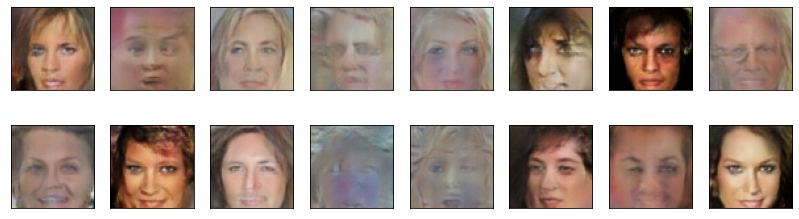

2023-06-22 19:15:36 | Epoch [19/20] | Batch 0/509 | d_loss: 1.1323 | g_loss: 0.9416
2023-06-22 19:16:09 | Epoch [19/20] | Batch 50/509 | d_loss: 1.0576 | g_loss: 1.0415
2023-06-22 19:16:42 | Epoch [19/20] | Batch 100/509 | d_loss: 1.1097 | g_loss: 0.9198
2023-06-22 19:17:15 | Epoch [19/20] | Batch 150/509 | d_loss: 1.1774 | g_loss: 0.7255
2023-06-22 19:17:48 | Epoch [19/20] | Batch 200/509 | d_loss: 1.1718 | g_loss: 0.8766
2023-06-22 19:18:20 | Epoch [19/20] | Batch 250/509 | d_loss: 1.0670 | g_loss: 0.8307
2023-06-22 19:18:53 | Epoch [19/20] | Batch 300/509 | d_loss: 1.0304 | g_loss: 0.9268
2023-06-22 19:19:26 | Epoch [19/20] | Batch 350/509 | d_loss: 1.1315 | g_loss: 0.8202
2023-06-22 19:19:59 | Epoch [19/20] | Batch 400/509 | d_loss: 1.0697 | g_loss: 0.9621
2023-06-22 19:20:32 | Epoch [19/20] | Batch 450/509 | d_loss: 1.1412 | g_loss: 1.0428
2023-06-22 19:21:05 | Epoch [19/20] | Batch 500/509 | d_loss: 1.1366 | g_loss: 0.9060


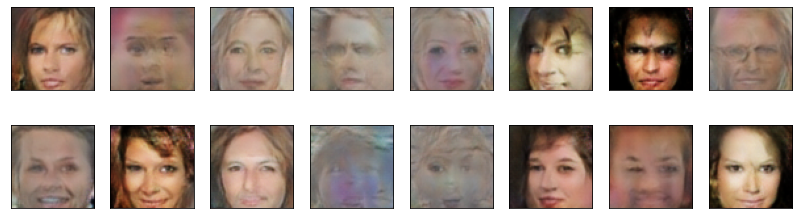

2023-06-22 19:21:12 | Epoch [20/20] | Batch 0/509 | d_loss: 1.1639 | g_loss: 0.8552
2023-06-22 19:21:45 | Epoch [20/20] | Batch 50/509 | d_loss: 1.1424 | g_loss: 0.8923
2023-06-22 19:22:18 | Epoch [20/20] | Batch 100/509 | d_loss: 1.1682 | g_loss: 1.0535
2023-06-22 19:22:51 | Epoch [20/20] | Batch 150/509 | d_loss: 1.0880 | g_loss: 0.7733
2023-06-22 19:23:24 | Epoch [20/20] | Batch 200/509 | d_loss: 1.1696 | g_loss: 1.0967
2023-06-22 19:23:57 | Epoch [20/20] | Batch 250/509 | d_loss: 1.2045 | g_loss: 1.0733
2023-06-22 19:24:30 | Epoch [20/20] | Batch 300/509 | d_loss: 1.0512 | g_loss: 0.9419
2023-06-22 19:25:03 | Epoch [20/20] | Batch 350/509 | d_loss: 1.1264 | g_loss: 0.6555
2023-06-22 19:25:36 | Epoch [20/20] | Batch 400/509 | d_loss: 1.0909 | g_loss: 0.8124
2023-06-22 19:26:09 | Epoch [20/20] | Batch 450/509 | d_loss: 1.1696 | g_loss: 0.9038
2023-06-22 19:26:42 | Epoch [20/20] | Batch 500/509 | d_loss: 1.0995 | g_loss: 0.8532


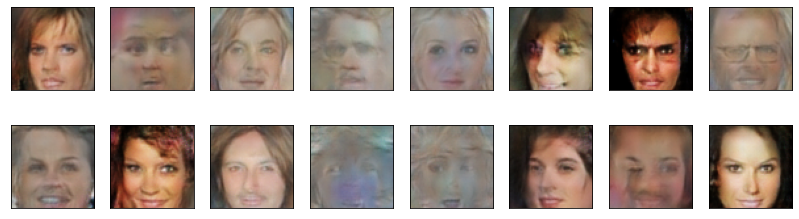

In [41]:
fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).float().to(device)

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        
        d_optimizer.zero_grad()

        # Calculate discriminator loss
        d_loss = discriminator_step(generator, discriminator, batch_size, latent_dim, real_images, d_optimizer)

        # Train the generator
        g_optimizer.zero_grad()

        # Calculate generator loss
        g_loss = generator_step(generator, discriminator, batch_size, latent_dim, g_optimizer)
        
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            d = d_loss['loss']
            g = g_loss['loss']
            losses.append((d, g))
            # print discriminator and generator loss
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d:.4f} | g_loss: {g:.4f}')
    
    # display images during training
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_latent_vector)
    display(generated_images)
    generator.train()

### Training losses

Plot the training losses for the generator and discriminator.

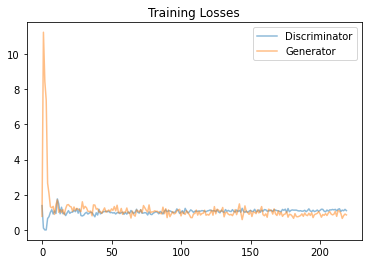

In [42]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:**

The dataset bias impacts the range of images that the network is able to generate since it only contains certain type of people with considerably similar characteristics. If the objective was to generate "celebrity" faces, then the database would be a great fit for that. Otherwise, a dataset with different faces of people would be needed. For example, if the objective was to generate faces of "non-celebrity" people or people with diverse ethnic backgrounds, then the dataset would need to be adjusted to be more balanced or representative of the target being sought.

About the model size, it could be argued that the the model still has room for improvement since it needs more complexity in order to reduce the loss and improve the quality of the generated images. With the current architecture the model might not be able to learn all the nuances of human faces, resulting on unrealistic o low quality images. To improve the model it's possible to increase the model size, as well as the images resolution.

Furthermore, optimizing the hyperparameters, training for more epochs, and trying different loss functions or combinations of them could potentially improve the model.

